In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline, make_union

from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import sequence

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

from server.ml_models.player_xgb import PlayerXGBData

from server.data_processors.feature_functions import (
    add_last_year_brownlow_votes,
    add_rolling_player_stats,
    add_cum_matches_played
)
from server.data_processors import (
    FeatureBuilder,
    PlayerDataStacker,
    OppoFeatureBuilder
)
from server.data_processors import FitzroyDataReader

FEATURE_FUNCS = [
    add_last_year_brownlow_votes,
    add_rolling_player_stats,
    add_cum_matches_played
]
DATA_TRANSFORMERS = [
    PlayerDataStacker().transform,
    FeatureBuilder(
        feature_funcs=FEATURE_FUNCS,
        index_cols=['team', 'year', 'round_number', 'player_id']
    ).transform
]
fitzroy = FitzroyDataReader()
DATA_READERS = [
    fitzroy.get_afltables_stats,
    fitzroy.match_results
]
START_DATE = '1965-01-01'

np.random.seed(42)

In [2]:
# Get player data, stack by team-match, and add player-relevant features

player_data = PlayerXGBData(data_readers=DATA_READERS,
                            data_transformers=DATA_TRANSFORMERS,
                            start_date=START_DATE,
                            train_years=(None, None),
                            test_years=(None, None))
player_data.data

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(['player_id', 'year'], group_keys=True)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'year' is both an index level and a column label.
Defau

at_home  rolling_behinds  \
team             year round_number player_id                             
Adelaide         1991 1            1                1         0.000000   
                                   3                1         0.000000   
                                   5                1         0.000000   
                                   8                1         0.000000   
                                   9                1         0.000000   
                                   17               1         1.000000   
                                   18               1         0.000000   
                                   26               1         0.000000   
                                   1289             1         0.000000   
                                   1316             1         1.000000   
                                   1921             1         2.000000   
                                   3785             1         0.000000   
                                   3990             1         0.000000   
                                   11504            1         1.000000   
                                   11505            1         1.000000   
                                   11507            1         1.000000   
                                   11509            1         0.000000   
                                   11510            1         0.000000   
                                   11512            1         1.000000   
                                   11513            1         0.000000   
                      2            1                1         0.000000   
                                   5                1         0.000000   
                                   8                1         0.000000   
                                   9                1         0.000000   
                                   17               1         1.000000   
                                   18               1         0.500000   
                                   26               1         0.000000   
                                   42               1         0.000000   
                                   1289             1         0.000000   
                                   1316             1         0.500000   
...                                               ...              ...   
Western Bulldogs 2016 26           12228            1         0.086957   
                                   12269            1         0.695652   
                                   12270            1         0.608696   
                                   12359            1         0.000000   
                                   12363            1         0.555556   
                                   12373            1         0.304348   
                                   12392            1         0.111111   
                                   12408            1         0.733333   
                      27           1450             1         0.043478   
                                   4084             1         0.086957   
                                   11731            1         0.434783   
                                   11788            1         0.000000   
                                   11833            1         0.434783   
                                   11898            1         0.130435   
                                   11974            1         0.434783   
                                   12042            1         0.608696   
                                   12043            1         0.695652   
                                   12122            1         0.391304   
                                   12126            1         0.043478   
                                   12166            1         0.217391   
                                   12167            1         1.043478   
                                   12203          

In [3]:
agg_data = PlayerXGBData(start_date=START_DATE,
                         train_years=(None, None),
                         test_years=(None, None))
agg_data.data

/app/server/data_processors/player_data_aggregator.py:59: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(self.index_cols + ['oppo_team'])
/app/server/data_processors/player_data_aggregator.py:59: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(self.index_cols + ['oppo_team'])
/app/server/data_processors/player_data_aggregator.py:59: FutureWarning: 'round_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(self.index_cols + ['oppo_team'])


team  year  round_number  \
team             year round_number                                         
Adelaide         1991 1                     Adelaide  1991             1   
                      2                     Adelaide  1991             2   
                      3                     Adelaide  1991             3   
                      4                     Adelaide  1991             4   
                      5                     Adelaide  1991             5   
                      6                     Adelaide  1991             6   
                      7                     Adelaide  1991             7   
                      9                     Adelaide  1991             9   
                      10                    Adelaide  1991            10   
                      11                    Adelaide  1991            11   
                      12                    Adelaide  1991            12   
                      13                    Adelaide  1991            13   
                      14                    Adelaide  1991            14   
                      16                    Adelaide  1991            16   
                      17                    Adelaide  1991            17   
                      18                    Adelaide  1991            18   
                      20                    Adelaide  1991            20   
                      21                    Adelaide  1991            21   
                      22                    Adelaide  1991            22   
                      24                    Adelaide  1991            24   
                 1992 1                     Adelaide  1992             1   
                      3                     Adelaide  1992             3   
                      4                     Adelaide  1992             4   
                      5                     Adelaide  1992             5   
                      6                     Adelaide  1992             6   
                      7                     Adelaide  1992             7   
                      8                     Adelaide  1992             8   
                      9                     Adelaide  1992             9   
                      10                    Adelaide  1992            10   
                      11                    Adelaide  1992            11   
...                                              ...   ...           ...   
Western Bulldogs 2015 18            Western Bulldogs  2015            18   
                      20            Western Bulldogs  2015            20   
                      21            Western Bulldogs  2015            21   
                      22            Western Bulldogs  2015            22   
                      23            Western Bulldogs  2015            23   
                      24            Western Bulldogs  2015            24   
                 2016 1             Western Bulldogs  2016             1   
                      2             Western Bulldogs  2016             2   
                      3             Western Bulldogs  2016             3   
                      4             Western Bulldogs  2016             4   
                      5             Western Bulldogs  2016             5   
                      6             Western Bulldogs  2016             6   
                      7             Western Bulldogs  2016             7   
                      8             Western Bulldogs  2016             8   
                      9             Western Bulldogs  2016             9   
                      10            Western Bulldogs  2016            10   
                      11            Western Bulldogs  2016            11   
                      12            Western Bulldogs  2016            12   
                      13            Western Bulldogs  2016            13   
                      16            Western Bulldogs  2016            16   
                    

In [4]:
# Separate data frame into features & labels, sorting columns to get categories first

from functools import partial

SORT_COLS = ['team', 'year', 'round_number', 'player_id']
CATEGORY_COLS = ['team', 'oppo_team', 'player_id']
MATCH_COLS = ['team', 'oppo_team', 'at_home', 'round_number', 'score', 'oppo_score', 'year']

def col_value(tm_group, col):
    if col in MATCH_COLS:
        return tm_group[col][-1]
    return 0

data = (player_data
        .data
        .join(agg_data.data.filter(regex='^oppo_last|^oppo_rolling'),
              on=('team', 'year', 'round_number'),
              how='left')
        .sort_index())

total_cols = CATEGORY_COLS + list(data.drop(CATEGORY_COLS, axis=1).columns)
    
max_player_id = data['player_id'].max()
team_match_groups = data.groupby(['team', 'year', 'round_number'])
max_n_players = team_match_groups.count().max().max()

# Pad team-matches with blank players for a consistent number when reshaping data
padding = []

for _, tm_group in team_match_groups:
    diff = max_n_players - len(tm_group)

    if diff > 0:
        group_col_value = partial(col_value, tm_group)
        index = [tuple((*tm_group.index.droplevel(3).values[-1], max_player_id + 1 + n)) for n in range(diff)]
        df_dict = {col: group_col_value(col) for col in data.columns}
        blank_row = (pd
                     .DataFrame(df_dict, index=index)
                     .assign(player_id=list(range(max_player_id + 1, max_player_id + 1 + diff))))

        padding.append(blank_row)
        
padded_df = pd.concat([data] + padding, sort=True)[total_cols].sort_index()
padded_df

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'round_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/usr/local/lib/python3.6/site-packages/ipykernel_launch

team  \
team             year round_number player_id                     
Adelaide         1991 1            1                  Adelaide   
                                   3                  Adelaide   
                                   5                  Adelaide   
                                   8                  Adelaide   
                                   9                  Adelaide   
                                   17                 Adelaide   
                                   18                 Adelaide   
                                   26                 Adelaide   
                                   1289               Adelaide   
                                   1316               Adelaide   
                                   1921               Adelaide   
                                   3785               Adelaide   
                                   3990               Adelaide   
                                   11504              Adelaide   
                                   11505              Adelaide   
                                   11507              Adelaide   
                                   11509              Adelaide   
                                   11510              Adelaide   
                                   11512              Adelaide   
                                   11513              Adelaide   
                                   12487              Adelaide   
                                   12488              Adelaide   
                                   12489              Adelaide   
                                   12490              Adelaide   
                                   12491              Adelaide   
                                   12492              Adelaide   
                      2            1                  Adelaide   
                                   5                  Adelaide   
                                   8                  Adelaide   
                                   9                  Adelaide   
...                                                        ...   
Western Bulldogs 2016 26           12487      Western Bulldogs   
                                   12488      Western Bulldogs   
                                   12489      Western Bulldogs   
                                   12490      Western Bulldogs   
                      27           1450       Western Bulldogs   
                                   4084       Western Bulldogs   
                                   11731      Western Bulldogs   
                                   11788      Western Bulldogs   
                                   11833      Western Bulldogs   
                                   11898      Western Bulldogs   
                                   11974      Western Bulldogs   
                                   12042      Western Bulldogs   
                                   12043      Western Bulldogs   
                                   12122      Western Bulldogs   
                                   12126      Western Bulldogs   
                                   12166      Western Bulldogs   
                                   12167      Western Bulldogs   
                                   12203      Western Bulldogs   
                                   12228      Western Bulldogs   
                                   12269      Western Bulldogs   
                                   12270      Western Bulldogs   
                                   12359      Western Bulldogs   
                                   12363      Western Bulldogs   
                                   12373      Western Bulldogs   
                                   12392      Western Bulldogs   
                                   12408      Western Bulldogs   
                                   12487      Western Bulldogs   
                                   12488      Western Bulldogs   
                                

In [5]:
# Create pipeline & reshape data inputs

features = padded_df.drop(['score', 'oppo_score', 'player_name'], axis=1)
labels = padded_df['score'] - padded_df['oppo_score']

n_players_per_team_match = int(padded_df.groupby(['team', 'year', 'round_number'])['team'].count().mean())
n_features = len(features.columns)
n_labels = 1

X_train = features[features['year'] < 2016]
X_test = features[features['year'] >= 2016]
y_train = labels.loc[X_train.index]
y_test = labels.loc[X_test.index]

cat_pipe = make_pipeline(ColumnSelector(cols=[0, 1, 2]), OrdinalEncoder())
num_pipe = make_pipeline(ColumnSelector(cols=list(range(3, n_features))), StandardScaler())
full_pipe = make_union(cat_pipe, num_pipe)

X_train_arr = full_pipe.fit_transform(X_train.values).reshape((-1, n_players_per_team_match, n_features))
X_test_arr = full_pipe.transform(X_test.values).reshape((-1, n_players_per_team_match, n_features))
y_train_arr = y_train.values.reshape((-1, n_players_per_team_match, 1))
y_test_arr = y_test.values.reshape((-1, n_players_per_team_match, 1))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'round_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to 

## CNN without regularization

In [6]:
n_teams = len(data['team'].drop_duplicates())
min_n_players = team_match_groups.count().min().min()
max_min_diff = max_n_players - min_n_players


team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='team')
oppo_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='oppo_team')
player_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='player')
stats_input = layers.Input(shape=(n_players_per_team_match, n_features - 3), dtype='float32', name='stats')

team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(team_input)
oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(oppo_team_input)
player_layer = layers.Embedding(max_player_id + max_min_diff + 1, 4, input_length=n_players_per_team_match)(player_input)

concated_layers = layers.concatenate([team_layer, oppo_team_layer, player_layer, stats_input])

conv_layer_1 = layers.Conv1D(32, 3, activation='relu')(concated_layers)
pool_layer_1 = layers.MaxPooling1D(2)(conv_layer_1)
conv_layer_2 = layers.Conv1D(32, 3, activation='relu')(pool_layer_1)
pool_layer_2 = layers.GlobalMaxPooling1D()(conv_layer_2)
output = layers.Dense(1, activation='linear')(pool_layer_2)

model = models.Model(
    inputs=[
        team_input,
        oppo_team_input,
        player_input,
        stats_input
    ],
    outputs=output
)
model.compile(loss='mean_absolute_error', optimizer='adam')

In [7]:
history = model.fit(
    [
        X_train_arr[:, :, 0],
        X_train_arr[:, :, 1],
        X_train_arr[:, :, 2],
        X_train_arr[:, :, 3:]
    ],
    y_train_arr[:, 0, :],
    epochs=100,
    validation_split=0.2,
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12028 samples, validate on 3008 samples
Epoch 1/100
12028/12028 [==============================] - 3s 226us/step - loss: 32.6729 - val_loss: 31.0740
Epoch 2/100
12028/12028 [==============================] - 2s 185us/step - loss: 29.7285 - val_loss: 30.4991
Epoch 3/100
12028/12028 [==============================] - 2s 183us/step - loss: 28.7403 - val_loss: 30.4933
Epoch 4/100
12028/12028 [==============================] - 2s 179us/step - loss: 27.9766 - val_loss: 30.7533
Epoch 5/100
12028/12028 [==============================] - 2s 196us/step - loss: 27.3029 - val_loss: 30.4684
Epoch 6/100
12028/12028 [==============================] - 2s 201us/step - loss: 26.6065 - val_loss: 30.6583
Epoch 7/100
12028/12028 [==============================] - 3s 271us/step - loss: 26.1333 - val_loss: 30.7601
Epoch 8/100
12028/12028 [==============================] - 2s 178us/step - loss: 25.7005 - val_loss: 31.1647
Epoch 9/100
12028/12028 [==============================] - 3s 210us/step - loss

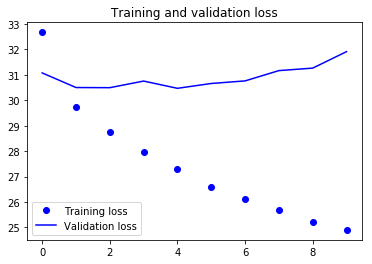

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## CNN with dropout

In [9]:
conv_layer_1 = layers.Conv1D(32, 3, activation='relu')(concated_layers)
pool_layer_1 = layers.MaxPooling1D(2)(conv_layer_1)

conv_layer_2 = layers.Conv1D(32, 3, activation='relu')(pool_layer_1)
dropout_layer_3 = layers.Dropout(rate=0.2)(conv_layer_2)

pool_layer_2 = layers.GlobalMaxPooling1D()(dropout_layer_3)
dropout_layer_4 = layers.Dropout(rate=0.4)(pool_layer_2)

output = layers.Dense(1, activation='linear')(dropout_layer_4)

do_model = models.Model(
    inputs=[
        team_input,
        oppo_team_input,
        player_input,
        stats_input
    ],
    outputs=output
)
do_model.compile(loss='mean_absolute_error', optimizer='adam')

do_history = model.fit(
    [
        X_train_arr[:, :, 0],
        X_train_arr[:, :, 1],
        X_train_arr[:, :, 2],
        X_train_arr[:, :, 3:]
    ],
    y_train_arr[:, 0, :],
    epochs=100,
    validation_split=0.2,
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Train on 12028 samples, validate on 3008 samples
Epoch 1/100
12028/12028 [==============================] - 2s 207us/step - loss: 24.5481 - val_loss: 31.4877
Epoch 2/100
12028/12028 [==============================] - 2s 202us/step - loss: 24.2750 - val_loss: 32.4148
Epoch 3/100
12028/12028 [==============================] - 3s 213us/step - loss: 24.0792 - val_loss: 32.6748
Epoch 4/100
12028/12028 [==============================] - 2s 181us/step - loss: 23.7331 - val_loss: 32.9611
Epoch 5/100
12028/12028 [==============================] - 2s 199us/step - loss: 23.4983 - val_loss: 32.9516
Epoch 6/100
12028/12028 [==============================] - 2s 191us/step - loss: 23.2972 - val_loss: 34.3444


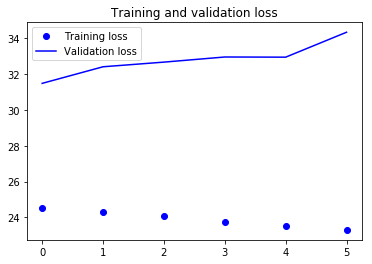

In [10]:
loss = do_history.history['loss']
val_loss = do_history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## CNN with l2 regularization

In [11]:
from tensorflow.keras import regularizers

conv_layer_1 = layers.Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001))(concated_layers)
pool_layer_1 = layers.MaxPooling1D(2)(conv_layer_1)
conv_layer_2 = layers.Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001))(pool_layer_1)
pool_layer_2 = layers.GlobalMaxPooling1D()(conv_layer_2)
output = layers.Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.001))(pool_layer_2)

l2_model = models.Model(
    inputs=[
        team_input,
        oppo_team_input,
        player_input,
        stats_input
    ],
    outputs=output
)
l2_model.compile(loss='mean_absolute_error', optimizer='adam')

l2_history = model.fit(
    [
        X_train_arr[:, :, 0],
        X_train_arr[:, :, 1],
        X_train_arr[:, :, 2],
        X_train_arr[:, :, 3:]
    ],
    y_train_arr[:, 0, :],
    epochs=100,
    validation_split=0.2,
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Train on 12028 samples, validate on 3008 samples
Epoch 1/100
12028/12028 [==============================] - 3s 221us/step - loss: 23.1872 - val_loss: 32.7714
Epoch 2/100
12028/12028 [==============================] - 2s 182us/step - loss: 22.9465 - val_loss: 34.3045
Epoch 3/100
12028/12028 [==============================] - 3s 214us/step - loss: 22.7102 - val_loss: 33.1961
Epoch 4/100
12028/12028 [==============================] - 2s 193us/step - loss: 22.6648 - val_loss: 34.1452
Epoch 5/100
12028/12028 [==============================] - 2s 189us/step - loss: 22.3989 - val_loss: 33.9466
Epoch 6/100
12028/12028 [==============================] - 2s 189us/step - loss: 22.1933 - val_loss: 34.5120


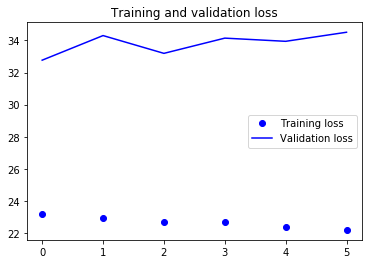

In [12]:
loss = l2_history.history['loss']
val_loss = l2_history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Unregularized has better performance

## CNN performance per year (unregularized model)

In [13]:
from sklearn.metrics import mean_absolute_error
from src.model.metrics import regression_accuracy

model_names = []
errors = []
accuracies = []
years = []

for year in range(2011, 2017):
    X_train = features[features['year'] < year]
    X_test = features[features['year'] == year]
    y_train = labels.loc[X_train.index]
    y_test = labels.loc[X_test.index]

    X_train_arr = full_pipe.fit_transform(X_train.values).reshape((-1, n_players_per_team_match, n_features))
    X_test_arr = full_pipe.transform(X_test.values).reshape((-1, n_players_per_team_match, n_features))
    y_train_arr = y_train.values.reshape((-1, n_players_per_team_match, 1))
    y_test_arr = y_test.values.reshape((-1, n_players_per_team_match, 1))
    
    model.fit(
        [
            X_train_arr[:, :, 0],
            X_train_arr[:, :, 1],
            X_train_arr[:, :, 2],
            X_train_arr[:, :, 3:]
        ],
        y_train_arr[:, 0, :],
        epochs=100,
        validation_split=0.2,
        callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3)],
        verbose=0
)

    y_pred = model.predict([
            X_test_arr[:, :, 0],
            X_test_arr[:, :, 1],
            X_test_arr[:, :, 2],
            X_test_arr[:, :, 3:]
    ])

    years.append(year)
    model_names.append('cnn')
    errors.append(mean_absolute_error(y_test_arr[:, 0, :], y_pred))
    accuracies.append(regression_accuracy(y_test_arr[:, 0, :], y_pred))
        
year_scores = pd.DataFrame({'model': model_names,
                            'year': years,
                            'error': errors,
                            'accuracy': accuracies}).astype({'year': int})
year_scores

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by 

,model,year,error,accuracy
0,cnn,2011,24.162071,0.795580
1,cnn,2012,23.821955,0.785714
2,cnn,2013,22.989314,0.796296
3,cnn,2014,26.160263,0.767196
4,cnn,2015,26.173100,0.800532
5,cnn,2016,31.561268,0.687500


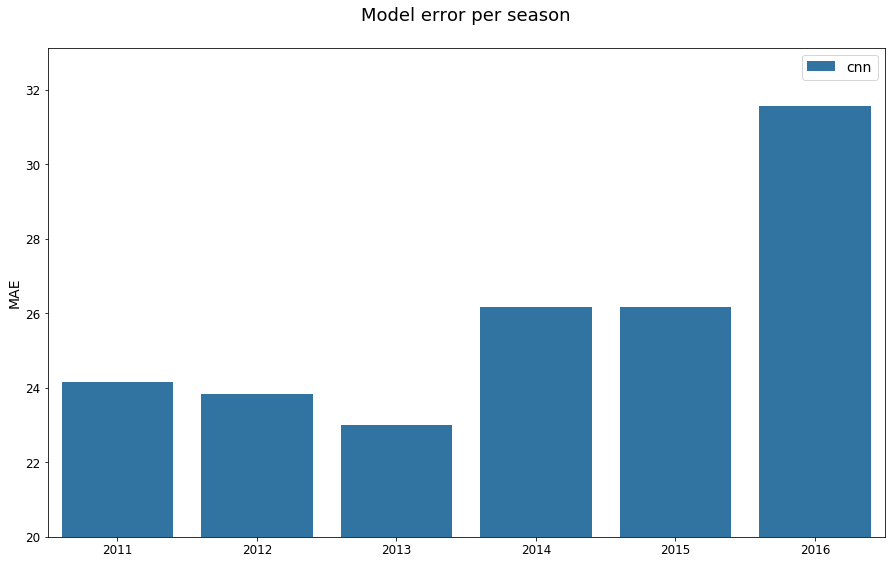

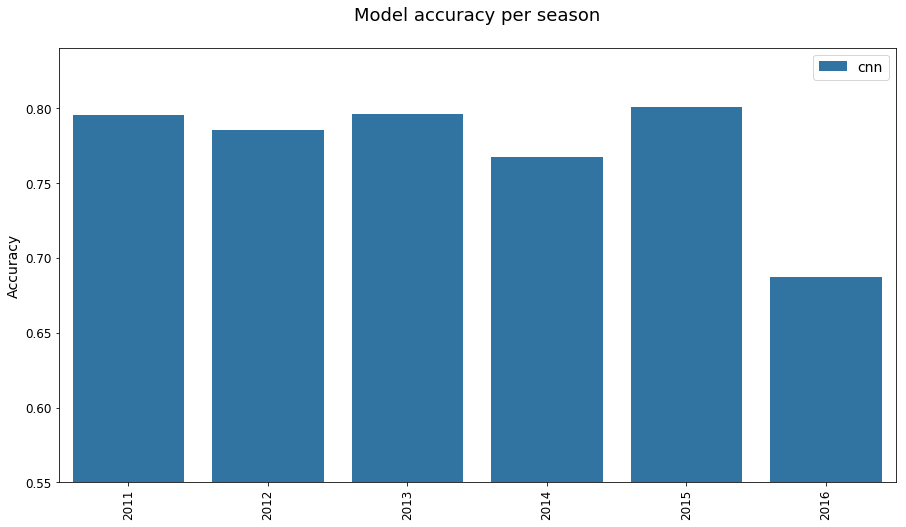

In [14]:
import seaborn as sns

# MAE scores
plt.figure(figsize=(15, 9))
sns.barplot(x='year', y='error', hue='model', data=year_scores)
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(bottom=20)
plt.title('Model error per season\n', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
plt.figure(figsize=(15, 8))
sns.barplot(x='year', y='accuracy', hue='model', data=year_scores)
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(bottom=0.55)
plt.title('Model accuracy per season\n', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

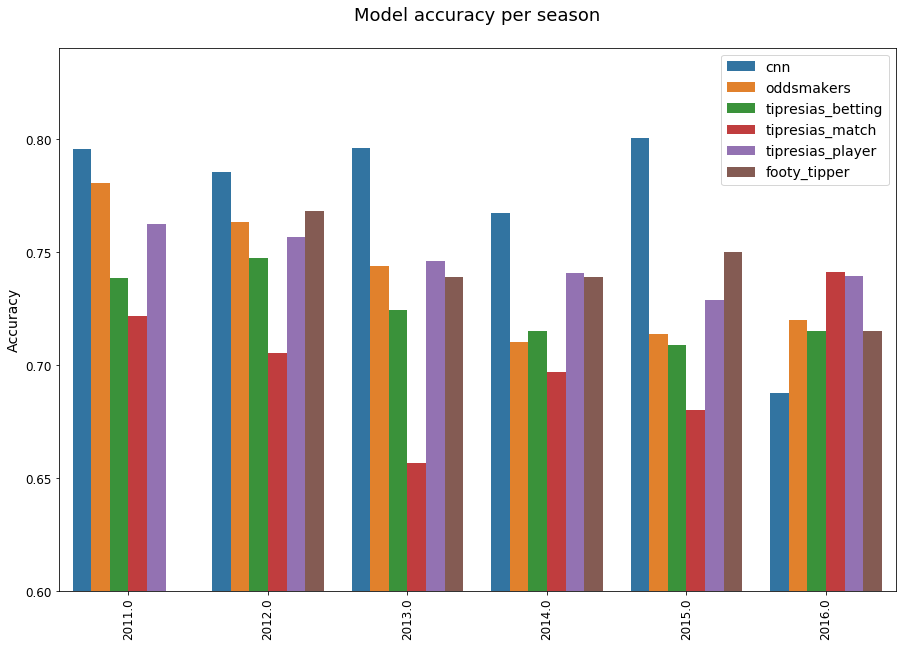

In [15]:
prediction_df = pd.read_csv('../data/model_predictions.csv')
prediction_scores = (prediction_df
                     .groupby(['model', 'year'])
                     .mean()['tip_point']
                     .reset_index()
                     .rename(columns={'tip_point': 'accuracy'}))
# Footy tipper accuracy scores taken from a trial that took too long to run,
# so I'm just copy pasting from a notebook
footy_tipper_scores = pd.DataFrame({'model': ['footy_tipper'] * len(range(2012, 2017)),
                                    'year': list(range(2012, 2017)),
                                    'error': [0] * len(range(2012, 2017)),
                                    'accuracy': [0.768116, 0.739130, 0.739130, 0.750000, 0.714976]})

all_year_scores = (pd
                   .concat([year_scores, prediction_scores, footy_tipper_scores], sort=True)
                   .reset_index(drop=True))

# Accuracy scores
plt.figure(figsize=(15, 10))
sns.barplot(x='year', y='accuracy', hue='model', data=all_year_scores[all_year_scores['year'] > 2010])
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(bottom=0.6)
plt.title('Model accuracy per season\n', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

## Basic RNN

In [38]:
lstm_1 = layers.LSTM(50, dropout=0.2, return_sequences=True)(concated_layers)
lstm_2 = layers.LSTM(50, dropout=0.2, return_sequences=True)(lstm_1)
lstm_3 = layers.LSTM(50, dropout=0.2)(lstm_2)
output = layers.Dense(1, activation='linear')(lstm_3)

rnn_model = models.Model(
    inputs=[
        team_input,
        oppo_team_input,
        player_input,
        stats_input
    ],
    outputs=output
)

rnn_model.compile(loss='mean_absolute_error', optimizer='adam')
rnn_history = model.fit(
    [
        X_train_arr[:, :, 0],
        X_train_arr[:, :, 1],
        X_train_arr[:, :, 2],
        X_train_arr[:, :, 3:]
    ],
    y_train_arr[:, 0, :],
    epochs=100,
    validation_split=0.2,
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Train on 12028 samples, validate on 3008 samples
Epoch 1/100
12028/12028 [==============================] - 3s 264us/step - loss: 9.1410 - val_loss: 43.3998
Epoch 2/100
12028/12028 [==============================] - 2s 194us/step - loss: 9.0561 - val_loss: 43.4478
Epoch 3/100
12028/12028 [==============================] - 2s 196us/step - loss: 9.1317 - val_loss: 43.3625
Epoch 4/100
12028/12028 [==============================] - 2s 191us/step - loss: 8.9603 - val_loss: 43.4897
Epoch 5/100
12028/12028 [==============================] - 2s 197us/step - loss: 9.0416 - val_loss: 42.9842
Epoch 6/100
12028/12028 [==============================] - 2s 201us/step - loss: 8.8909 - val_loss: 43.5706
Epoch 7/100
12028/12028 [==============================] - 2s 200us/step - loss: 8.8175 - val_loss: 43.5760
Epoch 8/100
12028/12028 [==============================] - 3s 208us/step - loss: 8.8238 - val_loss: 43.2951
Epoch 9/100
12028/12028 [==============================] - 3s 215us/step - loss: 8.6915

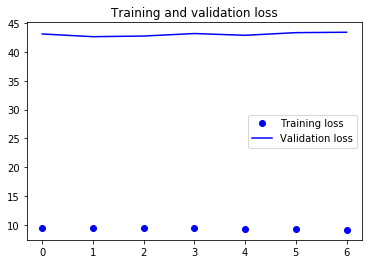

In [37]:
loss = rnn_history.history['loss']
val_loss = rnn_history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()